In [1]:
import mne
import scipy.io

# Load the .mat file containing electrode locations
mat_data = scipy.io.loadmat('5f_data/5F-SubjectE-160321-5St-SGLHand-HFREQ.mat')

o_data = mat_data['o']

# Access data within 'o' (assuming 'o' is the main data structure you're interested in)
id_data = o_data['id']
tag_data = o_data['tag']
samp_freq_data = o_data['sampFreq']
nS_data = o_data['nS']
marker_data = o_data['marker']
data_data = o_data['data']
chnames_data = o_data['chnames']
binsuV_data = o_data['binsuV']

eeg_data = data_data[0][0]
chnames = chnames_data[0][0]
channel_name_arrays=chnames.tolist()
channel_names = [name[0] for name in channel_name_arrays]
channel_names = [name[0] for name in channel_names]

markers = [marker[0] for marker in marker_data][0]
freq=samp_freq_data[0][0][0][0]
info = mne.create_info(channel_names, freq)
raw = mne.io.RawArray(eeg_data.T, info)

Creating RawArray with float64 data, n_channels=22, n_times=3585000
    Range : 0 ... 3584999 =      0.000 ...  3584.999 secs
Ready.


In [9]:
markers

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

In [36]:
#raw.plot(start=40, duration=10)
for ch in raw.ch_names:
    raw.set_channel_types({ch: 'eeg'})
print(raw.get_channel_types())
channels_to_drop = ['O1', 'O2', 'A1', 'A2','X5']
#referenced
raw.set_eeg_reference(ref_channels=['A1', 'A2'])
raw = raw.pick_channels(ch_names=[ch for ch in raw.ch_names if ch not in channels_to_drop])

montage =  mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

#mne resample  
raw_resampled = raw.copy().resample(250.0, npad='auto')

['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/509208631.py:3: RuntimeWarning: The unit for channel(s) Fp1 has changed from NA to V.
  raw.set_channel_types({ch: 'eeg'})
/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/509208631.py:3: RuntimeWarning: The unit for channel(s) Fp2 has changed from NA to V.
  raw.set_channel_types({ch: 'eeg'})
/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/509208631.py:3: RuntimeWarning: The unit for channel(s) F3 has changed from NA to V.
  raw.set_channel_types({ch: 'eeg'})
/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/509208631.py:3: RuntimeWarning: The unit for channel(s) F4 has changed from NA to V.
  raw.set_channel_types({ch: 'eeg'})
/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/509208631.py:3: RuntimeWarning: The unit for channel(s) C3 has changed from NA to V.
  raw.set_channel_types({ch: 'eeg'})
/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_4215

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [37]:
#make event arr
import numpy as np
import pandas as pd
import torch

# Your data array
data_array = markers

# Initialize variables to keep track of the current value and its count
current_value = None
current_count = 0
value_counts = []
current_pos = 0

# Iterate through the data array
for pos, value in enumerate(data_array.flatten()):
    if value == current_value:
        # Increment the count for consecutive occurrences
        current_count += 1
    else:
        # If a new value is encountered, add the previous value and count to the list
        if current_value is not None:
            value_counts.append((current_value, current_count,current_pos))
        # Reset count for the new value
        current_value = value
        current_pos = pos
        current_count = 1
        

# Add the last value and its count to the list
if current_value is not None:
    value_counts.append((current_value, current_count, current_pos))

# Create a DataFrame to present the consecutive counts in a table format
counts_table = pd.DataFrame(value_counts, columns=['Value', 'Consecutive Count','onset'])

# Print the table
print(counts_table)
csv_file_path = 'consecutive_counts.csv'

# Use the to_csv method to save the DataFrame to a CSV file
#counts_table.to_csv(csv_file_path, index=False)

positions_in_samples = counts_table[counts_table["Value"].isin ([1,2,3,4,5,0])]['onset']
positions_in_samples = (positions_in_samples / freq) * 250

events = counts_table[counts_table["Value"].isin ([1,2,3,4,5,0])]['Value']
event_arr = np.array([positions_in_samples, np.zeros(len(positions_in_samples)), events]).T.astype(int)
index_first_one = np.argmax(event_arr[:, 2] == 1)

# Keep only the rows from index_first_one and after, where the last column is 0 or 1
event_arr = event_arr[index_first_one:]

      Value  Consecutive Count    onset
0         0             148576        0
1        99               1029   148576
2         0               4013   149605
3        99               1025   153618
4         0               3014   154643
...     ...                ...      ...
1924      0               2341  3574010
1925      5               1281  3576351
1926      0                  2  3577632
1927     92               1026  3577634
1928      0               6340  3578660

[1929 rows x 3 columns]


In [38]:
event_arr

array([[ 41547,      0,      1],
       [ 42253,      0,      0],
       [ 42857,      0,      4],
       ...,
       [894087,      0,      5],
       [894408,      0,      0],
       [894665,      0,      0]])

In [39]:
import pandas as pd
#make csv
df = pd.DataFrame(event_arr, columns=['timestamps', 'source', 'target'])

for i in range(len(df['source'])):
    if i % 2 != 0:
        df['source'][i] = df['target'][i-1]
df.columns = ["ts","u","i"]


# Initialize empty lists to store edge labels and edge indices
edge_labels = []
edge_indices = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    u = row['u']
    i = row['i']
    
    # Skip rows where both u and i are zero, as they don't represent edges
    
    edge_labels.append(f'u{u}_i{i}')
    edge_indices.append(index)

# Create a new DataFrame for edge labels and indices
edges_df = pd.DataFrame({'label': edge_labels, 'idx': edge_indices})

# Horizontal Concatenation (Side by Side)
new_df = pd.concat([df, edges_df], axis=1)

In [40]:
#make empty state 1
new_df['u'] = new_df['u'] + 1
new_df['i'] = new_df['i'] + 1
new_df


,ts,u,i,label,idx
0,41547,1,2,u0_i1,0
1,42253,2,1,u1_i0,1
2,42857,1,5,u0_i4,2
3,43181,5,1,u4_i0,3
4,43583,1,3,u0_i2,4
...,...,...,...,...,...
1910,893179,1,6,u0_i5,1910
1911,893502,6,1,u5_i0,1911
1912,894087,1,6,u0_i5,1912
1913,894408,6,1,u5_i0,1913


In [41]:
edgefeatures = []

# Assuming you have a NumPy array `data` with your data
data = raw_resampled.get_data()

# Assuming `new_df['ts']` contains your 'ts' values
for i in new_df['ts']:
    edgefeatures.append(data[:, i:i+251])

edgefeatures = np.array(edgefeatures)  # Convert the list to a NumPy array


In [42]:
edgefeatures.shape

(1915, 17, 251)

In [43]:
#add embeddings
import math
import torch

def positionalencoding3d(d_model, x, y, z):
    if d_model % 6 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with odd dimension (got dim={:d})".format(d_model))
    
    # Calculate the positional encodings for X, Y, and Z separately
    x_encoding = torch.sin(x * (2 ** torch.arange(0, d_model, 3) / d_model))
    y_encoding = torch.cos(y * (2 ** torch.arange(1, d_model, 3) / d_model))
    z_encoding = torch.sin(z * (2 ** torch.arange(2, d_model, 3) / d_model))

    # Combine the encodings
    position_encoding = x_encoding + y_encoding + z_encoding
    
    return position_encoding


ch_names = montage.ch_names
pos = montage.get_positions()

# Specify the dimensionality of the encoding
d_model = 12
embeddings = [] 
# Calculate the positional encoding
for name in raw.ch_names:
    x=pos['ch_pos'][name][0]
    y=pos['ch_pos'][name][1]
    z=pos['ch_pos'][name][2]
    print(name,x,y)
    position_encoded = positionalencoding3d(d_model,x,y,z)
    embeddings.append(position_encoded)

embeddings = torch.stack(embeddings)


Fp1 -0.0294367 0.08391710000000001
Fp2 0.029872299999999997 0.0848959
F3 -0.0502438 0.0531112
F4 0.0518362 0.0543048
C3 -0.06535809999999999 -0.0116317
C4 0.06711790000000001 -0.0109003
P3 -0.0530073 -0.0787878
P4 0.0556667 -0.0785602
F7 -0.0702629 0.0424743
F8 0.0730431 0.0444217
T3 -0.0841611 -0.0160187
T4 0.0850799 -0.0150203
T5 -0.0724343 -0.0734527
T6 0.0730557 -0.07306829999999999
Fz 0.0003122 0.058512
Cz 0.0004009 -0.009167
Pz 0.0003247 -0.08111499999999999


In [342]:
raw.ch_names

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'C3',
 'C4',
 'P3',
 'P4',
 'F7',
 'F8',
 'T3',
 'T4',
 'T5',
 'T6',
 'Fz',
 'Cz',
 'Pz']

In [44]:
# add 17 4 to (1915, 17, 250),17, 251, 5
edgetensor = torch.from_numpy(edgefeatures).view(17,-1)
datapoints_length = edgetensor.shape[-1]

electrode_embeddings_expanded = embeddings.unsqueeze(1).expand(-1, datapoints_length, -1)
combined_data = torch.cat((electrode_embeddings_expanded, edgetensor.unsqueeze(-1)), dim=2)
combined_data.shape

torch.Size([17, 480665, 5])

In [45]:
combined_data.view(1915, 17,-1,5).shape

torch.Size([1915, 17, 251, 5])

In [46]:
#now reshape to 1915
final_edgefeature = combined_data.view(1915, -1)   
np.save('gnnbackup/processed/ml_5f.npy', final_edgefeature)

In [47]:
new_df.to_csv('gnnbackup/processed/ml_5f.csv', index=False)

In [338]:
epochs = mne.Epochs(raw_resampled, events=event_arr, event_id=None, tmin=0, tmax=1, baseline=None, preload=True,proj=False)

Not setting metadata
1915 matching events found
No baseline correction applied
Using data from preloaded Raw for 1915 events and 251 original time points ...
0 bad epochs dropped


In [340]:
epochs.save('5fepochs.fif', overwrite=True)


/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/45517765.py:1: RuntimeWarning: This filename (5fepochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save('5fepochs.fif', overwrite=True)


In [49]:
# do node feature which is erps 
nodefeatures=[]
rawerps=[]
for event in [0,1,2,3,4,5]:
    finger_tensor = torch.from_numpy(epochs[str(event)].average(picks='all').get_data()) 
    rawerps.append(finger_tensor)
    electrode_embeddings=embeddings
    electrode_embeddings_expanded = electrode_embeddings.unsqueeze(1).expand(-1, 251, -1)
  
    combined_feature = torch.cat((electrode_embeddings_expanded, finger_tensor.unsqueeze(-1)), dim=2)
    print(combined_feature.shape)
    flattened_embeddings = combined_feature.view(-1)
    print(flattened_embeddings.shape)
    flattened_embeddings_np = flattened_embeddings.detach().numpy()
    nodefeatures.append(flattened_embeddings_np)

nodefeatures_array = np.array(nodefeatures)
erps_array = np.array(rawerps)
print(nodefeatures_array.shape)
np.save('ml_5f_node.npy', nodefeatures_array)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
(6, 21335)


In [55]:
nodefeatures_array.reshape(6,-1).shape


(6, 21335)

In [56]:
final_edgefeature.reshape(1915,-1).shape

torch.Size([1915, 21335])

In [57]:
edgetensor.shape

torch.Size([17, 480665])

In [63]:
testerp = rawerps[0].detach().numpy().astype(float)

In [64]:
fft=mne.time_frequency.stft(testerp, 8, tstep=None, verbose=None)

Number of frequencies: 5
Number of time steps: 63


In [67]:
fft.shape

(17, 5, 63)

In [131]:
ffts=[]
for erp in rawerps:
    erp=erp.detach().numpy().astype(float)
    fft=mne.time_frequency.stft(erp, 128, tstep=None, verbose=None)
    ffts.append(fft)

Number of frequencies: 65
Number of time steps: 4
Number of frequencies: 65
Number of time steps: 4
Number of frequencies: 65
Number of time steps: 4
Number of frequencies: 65
Number of time steps: 4
Number of frequencies: 65
Number of time steps: 4
Number of frequencies: 65
Number of time steps: 4


In [132]:
ffts_array = np.array(ffts)

In [341]:
ffts_array.shape

(6, 17, 65, 4)

In [137]:
250/128

1.953125

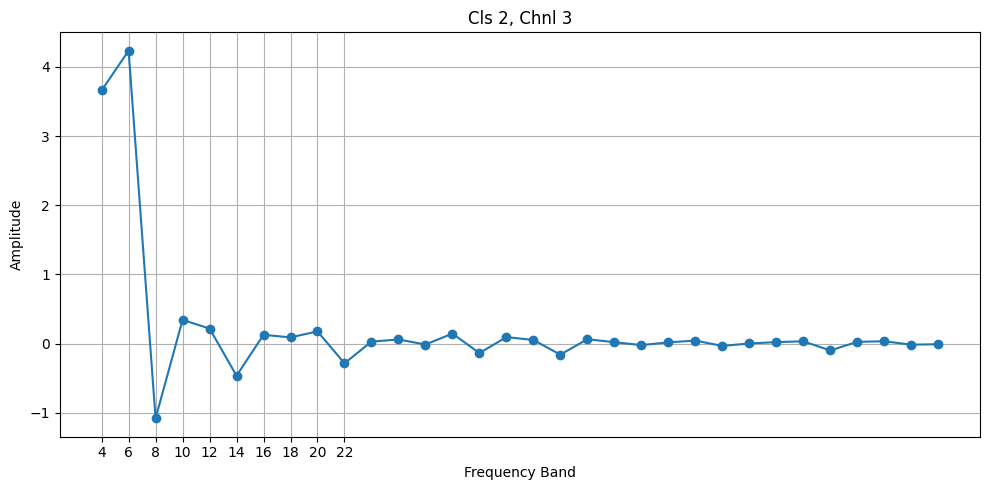

In [152]:
import matplotlib.pyplot as plt
import numpy as np

# Averaging across timepoints
avg_data = np.mean(ffts_array, axis=-1)  # Now the resultant shape would be (6, 17, 17)

# Considering only the first 10 frequency bands for plotting
avg_data = avg_data[:, :, 1:33]  # Shape becomes (6, 17, 10)

# Selecting a specific class and channel to plot
selected_class_idx = 1  # Change to the index of your desired class (0-indexed)
selected_channel_idx = 2  # Change to the index of your desired channel (0-indexed)

# Plotting
plt.figure(figsize=(10,5))
plt.plot(avg_data[selected_class_idx, selected_channel_idx], marker='o')
plt.title(f'Cls {selected_class_idx + 1}, Chnl {selected_channel_idx + 1}')
plt.grid(True)
plt.xticks(range(10), labels=[str(2+i*2) for i in range(1, 11)])  # Adjust the labels to match your frequency bands
plt.xlabel('Frequency Band')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [171]:
250/128

1.953125

/Users/gongqianxi/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


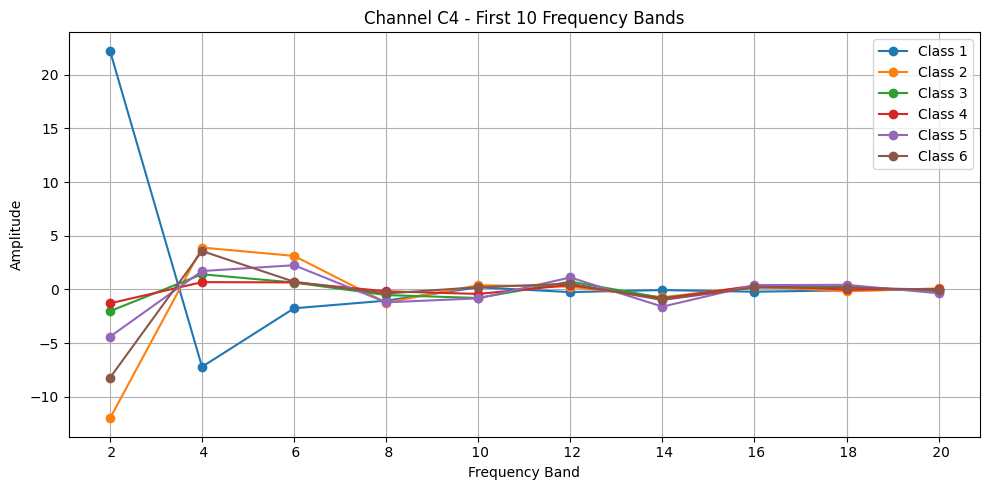

In [187]:
import matplotlib.pyplot as plt
import numpy as np

# Averaging across timepoints
avg_data = np.mean(ffts_array, axis=-1)  # Resultant shape: (6, 17, 33)

# Considering only the first 10 frequency bands for plotting
avg_data = avg_data[:, :, :10]  # Shape becomes (6, 17, 10)

# Selecting a specific channel to plot
selected_channel_idx = 5  # Change to the index of your desired channel (0-indexed)

# Plotting
plt.figure(figsize=(10,5))

for class_idx in range(avg_data.shape[0]):  # Looping over all the classes
    plt.plot(avg_data[class_idx, selected_channel_idx], marker='o', label=f'Class {class_idx + 1}')
    
plt.title(f'Channel {raw.ch_names[selected_channel_idx] } - First 10 Frequency Bands')
plt.grid(True)
plt.xticks(range(10), labels=[f' {(i+1)*2}' for i in range(10)])  # Adjust the labels to match your frequency bands
plt.xlabel('Frequency Band')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


In [188]:
selected_arr=ffts_array[:,:,1:20,:]
selected_arr.shape

(6, 17, 19, 4)

In [198]:
embeddings.shape

torch.Size([17, 4])

In [243]:
#addition
# Given tensors
data_tensor = ffts_tensor.reshape((6, 17, 4,19,1))  # classes, channels, timestamp, features, 1
embedding_tensor = embeddings   # Replace with your actual embedding tensor

# Expand the embedding tensor to match the shape of data_tensor
expanded_embedding = embedding_tensor[None, :, :, None, None]  # Shape: (17, 4, 1, 1)
print(expanded_embedding.shape)

# Expand the new dimensions to match the shape of data_tensor
expanded_embedding = expanded_embedding.expand(6, 17, 4, 19,4)  # Shape: (17, 4, 19, 4)
print(expanded_embedding.shape)
# Now, add the expanded_embedding tensor to the data_tensor
add_tensor = data_tensor.expand(6, 17, 4, 19,4) + expanded_embedding
add_tensor.shape

torch.Size([1, 17, 4, 1, 1])
torch.Size([6, 17, 4, 19, 4])


torch.Size([6, 17, 4, 19, 4])

In [194]:
#connocation

import torch

# Suppose you have the following tensors
ffts_tensor = torch.from_numpy(ffts_array[:,:,1:20,:])  # Replace with actual data
electrode_embedding = embeddings  # Replace with actual embeddings

# Add a new dimension to the electrode embedding tensor and expand it to match the ffts_tensor shape
expanded_embedding = electrode_embedding[:, :, None, None, None]  # Shape: (17, 4, 1, 1, 1)

# Now, expand the new dimensions to match the ffts_tensor shape
expanded_embedding = expanded_embedding.expand(17, 4, 6, 19, 4)  # Shape: (17, 4, 6, 19, 4)

# Permute the expanded_embedding tensor to match the ffts_tensor shape
expanded_embedding = expanded_embedding.permute(2, 0, 3, 4, 1)  # Shape: (6, 17, 19, 4, 4)

# Create a new dimension in ffts_tensor and concatenate with the expanded_embedding tensor
combined_tensor = torch.cat((ffts_tensor.unsqueeze(-1), expanded_embedding), dim=4)  # Shape: (6, 17, 19, 4, 5)
combined_tensor.shape

torch.Size([6, 17, 19, 4, 5])

In [267]:
add_tensor.shape

torch.Size([6, 17, 4, 19, 4])

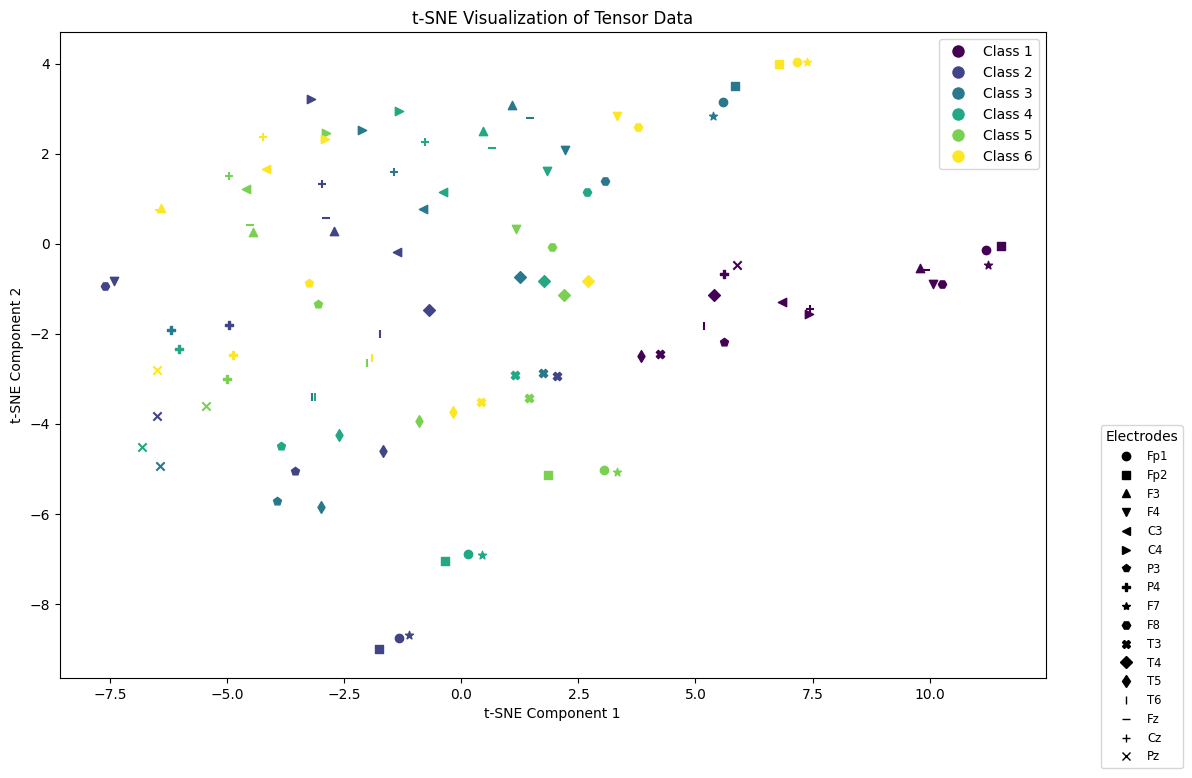

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
# Your tensor
tensor_data =  torch.abs(combined_tensor)  # Replace with your actual tensor
tensor_data_flat = tensor_data.reshape((6 * 17, -1)).numpy()  # Flatten the last three dimensions

# Apply t-SNE
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tensor_data_flat)

# Colors and Markers
colors = plt.cm.viridis(np.linspace(0, 1, 6))  # 6 colors for 6 classes
markers = ['o', 's', '^', 'v', '<', '>', 'p', 'P', '*', 'H', 'X', 'D', 'd', '|', '_', '+', 'x']  # 17 markers for 17 electrodes
electrodes = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

plt.figure(figsize=(12, 8))

for class_idx in range(6):
    for electrode_idx in range(17):
        idx = class_idx * 17 + electrode_idx
        plt.scatter(transformed_data[idx, 0], transformed_data[idx, 1], 
                    color=colors[class_idx], marker=markers[electrode_idx], 
                    label=f"Class {class_idx + 1}, Electrode {electrode_idx + 1}")

# You can optionally add a legend, but it might be too crowded. 
# To mitigate the crowding, you could make a separate legend for colors and markers, 
# or simply annotate some points directly on the plot.
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Create a legend for each class (colors)
class_patches = [mpatches.Patch(color=colors[i], label=f'Class {i+1}') for i in range(6)]

# Create a legend for each electrode (markers)
electrode_lines = [mlines.Line2D([], [], color='black', marker=markers[i], linestyle='None', label=electrodes[i]) for i in range(17)]

# Your actual scatter plotting code...
class_legend = [plt.Line2D([0], [0], marker='o', color='w', label=f'Class {i+1}', markersize=10, markerfacecolor=colors[i]) for i in range(6)]
first_legend = plt.legend(handles=class_legend, loc='upper right')

# Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)
# Adding legends
plt.legend(handles=class_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title='Classes', fontsize='small')
plt.legend(handles=electrode_lines, bbox_to_anchor=(1.05, 0.4), loc='upper left', title='Electrodes', fontsize='small')

plt.title("t-SNE Visualization of Tensor Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()



In [310]:
from scipy.spatial.distance import euclidean

# Number of classes and electrodes
num_classes = 6
num_electrodes = 17  # or len(electrodes)
distances = {}

# Iterate over each electrode
for electrode_idx in range(num_electrodes):
    electrode_distances = []
    
    # Compare each class's electrode with every other class's electrode
    for class1_idx in range(num_classes):
        for class2_idx in range(class1_idx + 1, num_classes):  # to avoid duplicate comparisons
            idx1 = class1_idx * num_electrodes + electrode_idx
            idx2 = class2_idx * num_electrodes + electrode_idx
            
            point1 = transformed_data[idx1]
            point2 = transformed_data[idx2]
            
            distance = euclidean(point1, point2)
            electrode_distances.append(distance)
    
    # Store the distances for the electrode
    electrode_name = electrodes[electrode_idx]
    distances[electrode_name] = electrode_distances

# distances will be a dictionary where keys are electrode names
# and values are lists of distances for that electrode between different classes.

# If you want to print the results
for electrode, dists in distances.items():
    print(f"{electrode}: {dists}")


Fp1: [15.221809387207031, 6.49990701675415, 12.971298217773438, 9.52018928527832, 5.800259113311768, 13.771719932556152, 2.3820998668670654, 5.7510199546813965, 15.367700576782227, 11.415383338928223, 8.560026168823242, 1.8173600435256958, 3.451964855194092, 12.99334716796875, 9.962929725646973]
Fp2: [16.016958236694336, 6.687345027923584, 13.778848648071289, 10.929211616516113, 6.2297258377075195, 14.623661994934082, 2.4105377197265625, 5.285146713256836, 15.54955768585205, 12.222161293029785, 9.511001586914062, 1.0617632865905762, 2.909696340560913, 13.14186954498291, 10.38052749633789]
F3: [12.554020881652832, 9.440654754638672, 9.824151992797852, 14.277034759521484, 16.27427864074707, 4.723450660705566, 3.8759348392486572, 1.7278029918670654, 3.7273409366607666, 0.8548892140388489, 6.211700916290283, 7.842423915863037, 5.395608425140381, 7.084850788116455, 2.0352094173431396]
F4: [17.494674682617188, 8.409456253051758, 8.618524551391602, 8.9805908203125, 7.7088541984558105, 10.0647

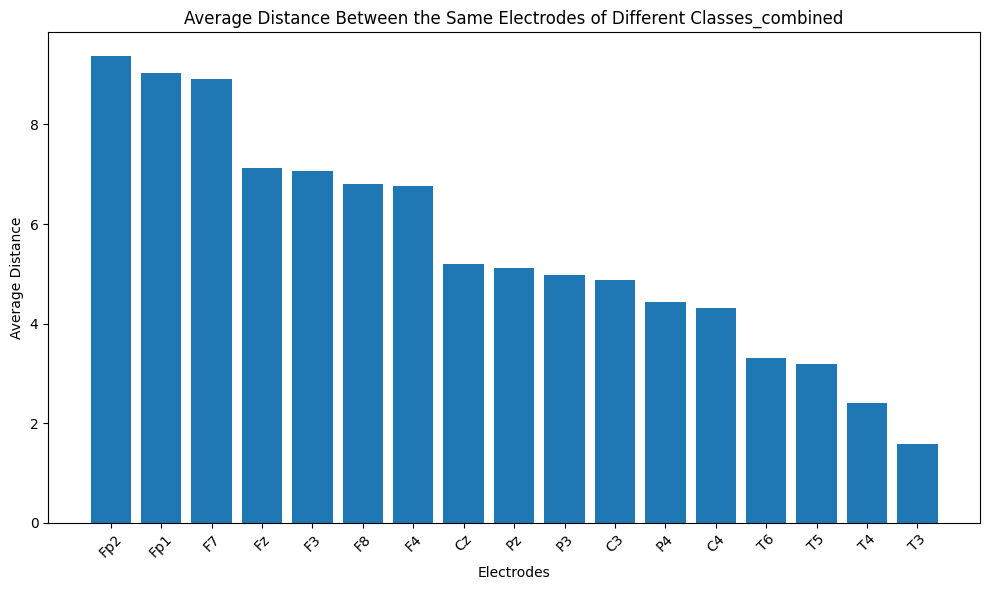

In [313]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the average distance for each electrode
avg_distances = {electrode: np.mean(dists) for electrode, dists in distances.items()}

# Sort electrodes by average distance
sorted_electrodes = sorted(avg_distances.keys(), key=lambda x: avg_distances[x], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_electrodes)), [avg_distances[ele] for ele in sorted_electrodes], align='center')
plt.xticks(range(len(sorted_electrodes)), sorted_electrodes, rotation=45)
plt.xlabel('Electrodes')
plt.ylabel('Average Distance')
plt.title('Average Distance Between the Same Electrodes of Different Classes_combined')
plt.tight_layout()
plt.show()


[('Fp1', 270.97402930259705), ('Fp2', 281.476026058197), ('F3', 211.69870626926422), ('F4', 203.04820597171783), ('C3', 146.2830183506012), ('C4', 129.560889929533), ('P3', 149.09969401359558), ('P4', 133.10018223524094), ('F7', 267.51752519607544), ('F8', 204.23883080482483), ('T3', 47.60542023181915), ('T4', 71.92747247219086), ('T5', 95.864022731781), ('T6', 99.00496098399162), ('Fz', 213.6042776107788), ('Cz', 155.94782876968384), ('Pz', 153.23672831058502)]
[('Fp2', 281.476026058197), ('Fp1', 270.97402930259705), ('F7', 267.51752519607544), ('Fz', 213.6042776107788), ('F3', 211.69870626926422), ('F8', 204.23883080482483), ('F4', 203.04820597171783), ('Cz', 155.94782876968384), ('Pz', 153.23672831058502), ('P3', 149.09969401359558), ('C3', 146.2830183506012), ('P4', 133.10018223524094), ('C4', 129.560889929533), ('T6', 99.00496098399162), ('T5', 95.864022731781), ('T4', 71.92747247219086), ('T3', 47.60542023181915)]


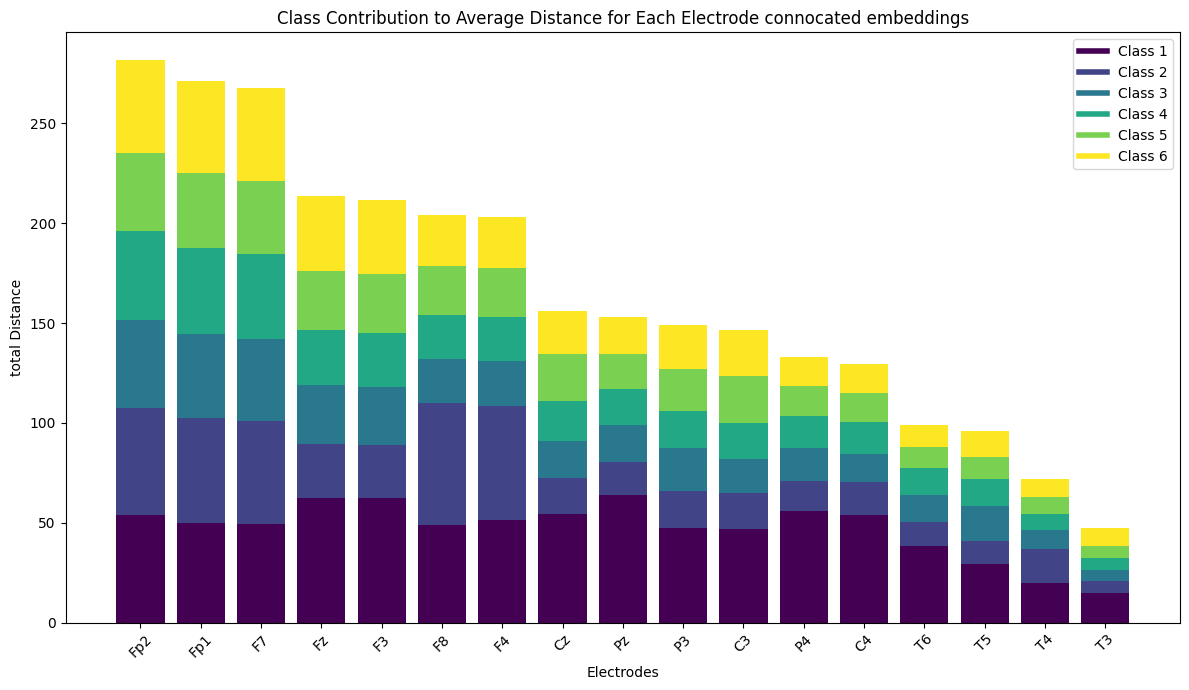

In [337]:

tensor_data =  torch.abs(combined_tensor)  # Replace with your actual tensor
tensor_data_flat = tensor_data.reshape((6 * 17, -1)).numpy()  # Flatten the last three dimensions

# Apply t-SNE
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tensor_data_flat)

from scipy.spatial.distance import euclidean

# Number of classes and electrodes
num_classes = 6
num_electrodes = 17  # or len(electrodes)
distances = {}

# Change distances dictionary to store distance for each class separately
for electrode_idx in range(num_electrodes):
    electrode_distances = {i:0 for i in range(num_classes)}
    for class1_idx in range(num_classes):
        for class2_idx in range(class1_idx + 1, num_classes):
            idx1 = class1_idx * num_electrodes + electrode_idx
            idx2 = class2_idx * num_electrodes + electrode_idx
            
            point1 = transformed_data[idx1]
            point2 = transformed_data[idx2]
            
            distance = euclidean(point1, point2)
            
            # Accumulating distance to both class1 and class2
            electrode_distances[class1_idx] += distance
            electrode_distances[class2_idx] += distance
    
    electrode_name = electrodes[electrode_idx]
    distances[electrode_name] = electrode_distances


# distances will be a dictionary where keys are electrode names
# and values are lists of distances for that electrode between different classes.

total_distances = [(electrode, sum(distances[electrode].values())) for electrode in distances.keys()]

print(total_distances)
# Sort the list of tuples based on total distance, in descending order
sorted_total_distances = sorted(total_distances, key=lambda x: x[1], reverse=True)

print(sorted_total_distances)
# Now, sorted_total_distances contains the electrodes sorted by their total distance.

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 7))

# Extract sorted electrodes and their total distances
sorted_electrodes, _ = zip(*sorted_total_distances)

# And then, while plotting:
for idx, electrode in enumerate(sorted_electrodes):
    bottom = 0
    for class_idx in range(num_classes):
        plt.bar(idx, distances[electrode][class_idx], bottom=bottom, color=colors[class_idx])
        bottom += distances[electrode][class_idx]

# Add legend
class_legend = [plt.Line2D([0], [0], color=colors[i], lw=4, label=f'Class {i+1}') for i in range(num_classes)]
plt.legend(handles=class_legend, loc='upper right')

# Adding labels and title
plt.xticks(range(len(sorted_electrodes)), sorted_electrodes, rotation=45)
plt.xlabel('Electrodes')
plt.ylabel('total Distance')
plt.title('Class Contribution to Average Distance for Each Electrode connocated embeddings')
plt.tight_layout()

plt.show()


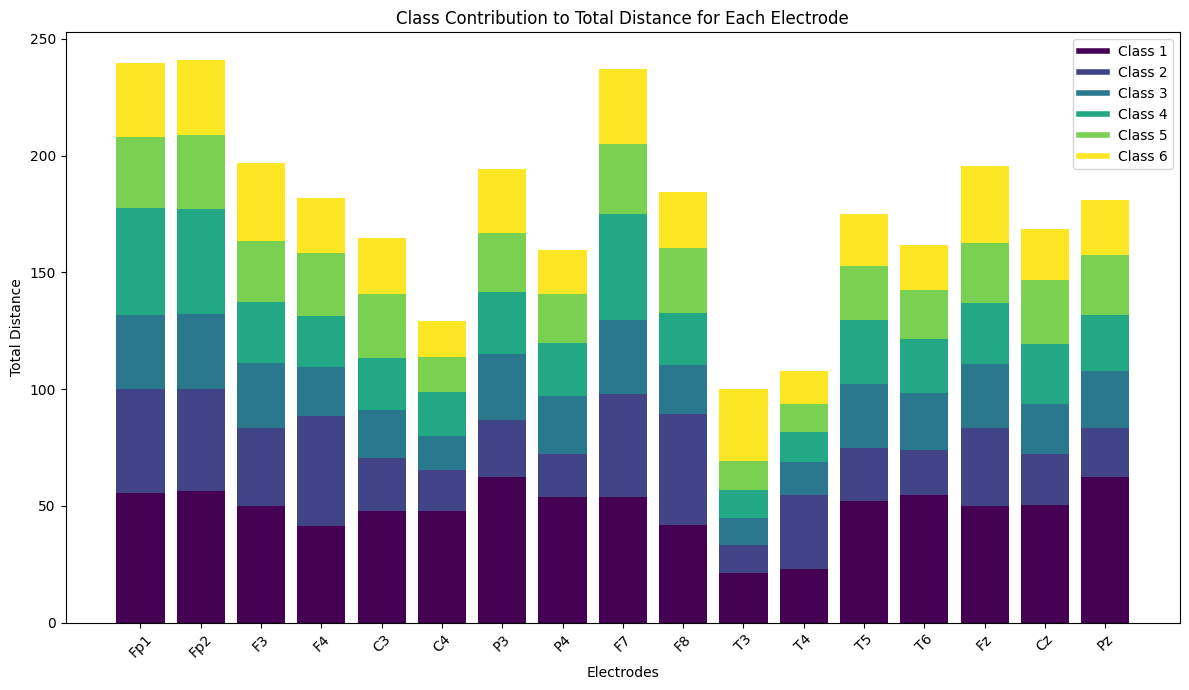

In [332]:
plt.figure(figsize=(12, 7))

# Extract sorted electrodes and their total distances
sorted_electrodes, _ = zip(*sorted_total_distances)

# For each sorted electrode, create a stacked bar
for idx, electrode in enumerate(sorted_electrodes):
    bottom = 0
    electrode_distances = distances[electrode]  # this is a dictionary with class_idx as keys
    for class_idx in range(num_classes):
        class_distance = electrode_distances[class_idx]  # Access the correct class distance
        plt.bar(idx, class_distance, bottom=bottom, color=colors[class_idx])
        bottom += class_distance

# Add legend, labels, and title
class_legend = [plt.Line2D([0], [0], color=colors[i], lw=4, label=f'Class {i+1}') for i in range(num_classes)]
plt.legend(handles=class_legend, loc='upper right')
plt.xticks(range(len(sorted_electrodes)), sorted_electrodes, rotation=45)
plt.xlabel('Electrodes')
plt.ylabel('Total Distance')
plt.title('Class Contribution to Total Distance for Each Electrode')
plt.tight_layout()

plt.show()
